In [5]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib
import os
from scipy.stats import pearsonr
from scipy.spatial.distance import braycurtis
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statannot import add_stat_annotation
from scipy.stats import spearmanr
%matplotlib inline
from matplotlib_venn import venn2
import scipy
from Bio import SeqIO

# Read taxonomy

In [6]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,394eda29c886632f514dd94b58381186,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.000000,f__Pasteurellaceae
1,06f825b512d903b9230e1a55d87359ee,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.997372,g__Streptococcus
2,923f521b9cf313f1f95c9367e09bbc1c,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.999995,g__Veillonella
3,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
4,4f5efd25dacb5d639316e7291ff6ff8b,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.997145,g__Neisseria


# Read metadata

In [7]:
df_meta = pd.read_csv("qiime2_output/SraRunTable.csv", index_col=0)
df_meta = df_meta[['env_medium','Host_disease','Library Name','Sample Name']]
df_meta.columns = ['BodySite','HostDisease','LibraryName','SampleName']
df_meta['SubjectID'] = [x.replace('Gut','HC').replace('Mouth','HC') if x.startswith('Gut') or x.startswith('Mouth') 
                        else x.replace('Gut','').replace('Mouth','') for x in df_meta.LibraryName]
df_meta['SubjectID'] = [x.replace('_','_0') if len(x.split('_')[1])==1 else x for x in df_meta['SubjectID']]
df_meta.index.name = 'SampleID'
df_meta['Disease'] = [x.split('_')[0] for x in df_meta.SubjectID]
df_meta.head()

,BodySite,HostDisease,LibraryName,SampleName,SubjectID,Disease
SampleID,,,,,,
SRR13302275,stool,periodontitis positive,CDGut_8,JI0168,CD_08,CD
SRR13302276,stool,periodontitis positive,CDGut_9,JI0170,CD_09,CD
SRR13302277,stool,periodontitis positive,CDGut_10,JI0171,CD_10,CD
SRR13302278,stool,periodontitis negative,CDGut_11,JI0172,CD_11,CD
SRR13302279,stool,periodontitis positive,CDGut_12,JI0173,CD_12,CD


In [8]:
set(df_meta.Disease)

{'CD', 'HC', 'UC'}

# Read count data (filter out samples with less than 1000 reads)

In [9]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1088


/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/2199734635.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]


#OTU ID,394eda29c886632f514dd94b58381186,06f825b512d903b9230e1a55d87359ee,923f521b9cf313f1f95c9367e09bbc1c,99deb3c5ecb022ec05609ebd1112a557,4f5efd25dacb5d639316e7291ff6ff8b,32f8fd11d2bee278d609a1d4ab767554,cd9401a6bce4a63af516d06d2a843f9d,d46e2205f0c6ecf67b51f83d111c509c,c6c3ab4e828fb40d6e05967b7aac9338,ca9c66d47347c03d0343d6fe03ed8636,...,3a182b5e7d0fcf5b1025e34c0a963e09,0b24027ea459399918ba5f4296ada9b4,1bcbd595fc80dafe064edfdfcae08fb8,eca538e0b9b601dfea22437417fec434,acccb7cec4d146864bc11d37da55dcd0,650aeb6747ae34ac802b446b5b149044,989a083f922229dd6b663ba46b1c9dc7,e13020761747ff138510eba6730461d0,f2d1ad47ff53d32e9a37aa2abaacc3ff,7eb40e9c821a22760e633a88b40d5939
SRR13302338,0.0000,0.001745,0.000826,0.000165,0.0,0.0,0.119537,0.296082,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302313,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000139,0.035057,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302344,0.0000,0.000000,0.000319,0.000000,0.0,0.0,0.000000,0.002868,0.057230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302297,0.0000,0.000383,0.000000,0.141964,0.0,0.0,0.000000,0.000236,0.059169,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302283,0.0038,0.000000,0.025550,0.000000,0.0,0.0,0.005660,0.006549,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare different oral fraction estimation methods

In [10]:
df_blast_HOMD = pd.read_csv("qiime2_output/asv-sequences/blast_HOMD/blast_HOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_HOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_fHOMD = pd.read_csv("qiime2_output/asv-sequences/blast_fHOMD/blast_fHOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_fHOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [11]:
all_subjects = list(set(df_meta.SubjectID))
res = []
for sub in all_subjects:
    curr_df = df_meta[df_meta.SubjectID==sub]
    gut_sample_id = list(curr_df[curr_df.BodySite=='stool'].index)
    assert len(gut_sample_id) == 1
    gut_sample_id = gut_sample_id[0]
    oral_sample_id = list(curr_df[curr_df.BodySite=='saliva'].index)
    assert len(oral_sample_id)==1
    oral_sample_id = oral_sample_id[0]
    
    if gut_sample_id not in list(df_relabun.index) or oral_sample_id not in list(df_relabun.index):
        continue
        
    disease = list(curr_df.Disease)[0]
    
    # oral sequences
    df_oral_seqs = df_relabun.loc[oral_sample_id]
    oral_seqs = list(df_oral_seqs[df_oral_seqs>0].index)
    
    # HOMD, all hits
    HOMD_hit = set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HOMD = df_relabun.loc[gut_sample_id, HOMD_hit].sum()
    
    # HOMD, hits present in oral cavity
    oral_seqs_w_HOMD_hit = set(oral_seqs).intersection(set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HOMD_hit].sum()
    
    # HOMD, hits found in oral cavity
    fecal_asvs_HOMD=list(df_relabun.loc[gut_sample_id][df_relabun.loc[gut_sample_id]>0].index)
    fecal_asvs_inferred_as_oral_HOMD = set(fecal_asvs_HOMD).intersection(set(df_blast_HOMD.query_accver))
    fecal_asvs_inferred_as_oral_present_in_oral_cavity_HOMD = fecal_asvs_inferred_as_oral_HOMD.intersection(oral_seqs)
    if len(fecal_asvs_inferred_as_oral_HOMD)>0:
        percent_hits_in_oral_cavity_HOMD = len(fecal_asvs_inferred_as_oral_present_in_oral_cavity_HOMD)/len(fecal_asvs_inferred_as_oral_HOMD)
    
    # fHOMD, all hits
    fHOMD_hit = set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_fHOMD = df_relabun.loc[gut_sample_id, fHOMD_hit].sum()
    
    # fHOMD, hits present in oral cavity
    oral_seqs_w_fHOMD_hit = set(oral_seqs).intersection(set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_fHOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_fHOMD_hit].sum()
    
    # fHOMD, hits found in oral cavity
    fecal_asvs_fHOMD=list(df_relabun.loc[gut_sample_id][df_relabun.loc[gut_sample_id]>0].index)
    fecal_asvs_inferred_as_oral_fHOMD = set(fecal_asvs_fHOMD).intersection(set(df_blast_fHOMD.query_accver))
    fecal_asvs_inferred_as_oral_present_in_oral_cavity_fHOMD = fecal_asvs_inferred_as_oral_fHOMD.intersection(oral_seqs)
    if len(fecal_asvs_inferred_as_oral_fHOMD)>0:
        percent_hits_in_oral_cavity_fHOMD = len(fecal_asvs_inferred_as_oral_present_in_oral_cavity_fHOMD)/len(fecal_asvs_inferred_as_oral_fHOMD)
    
    # HMPv35oral, all hits
    HMPv35oral_hit = set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HMPv35oral = df_relabun.loc[gut_sample_id, HMPv35oral_hit].sum()
    
    # HMPv35oral, hits present in oral cavity
    oral_seqs_w_HMPv35oral_hit = set(oral_seqs).intersection(set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HMPv35oral_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HMPv35oral_hit].sum()
    
    # HMPv35oral, hits found in oral cavity
    fecal_asvs_HMPv35oral=list(df_relabun.loc[gut_sample_id][df_relabun.loc[gut_sample_id]>0].index)
    fecal_asvs_inferred_as_oral_HMPv35oral = set(fecal_asvs_HMPv35oral).intersection(set(df_blast_HMPv35oral.query_accver))
    fecal_asvs_inferred_as_oral_present_in_oral_cavity_HMPv35oral = fecal_asvs_inferred_as_oral_HMPv35oral.intersection(oral_seqs)
    if len(fecal_asvs_inferred_as_oral_HMPv35oral)>0:
        percent_hits_in_oral_cavity_HMPv35oral = len(fecal_asvs_inferred_as_oral_present_in_oral_cavity_HMPv35oral)/len(fecal_asvs_inferred_as_oral_HMPv35oral)
    
    if oral_frac_HOMD==0:
        res.append([gut_sample_id, 'HOMD', 0, 0, np.NaN, oral_frac_HOMD, 1.0, disease])
    else:
        res.append([gut_sample_id, 'HOMD', len(fecal_asvs_inferred_as_oral_HOMD), len(fecal_asvs_inferred_as_oral_present_in_oral_cavity_HOMD),
                    percent_hits_in_oral_cavity_HOMD, oral_frac_HOMD, oral_frac_HOMD_overlap/oral_frac_HOMD, disease])
        
    if oral_frac_fHOMD==0:
        res.append([gut_sample_id, 'fHOMD', 0, 0, np.NaN, oral_frac_fHOMD, 1.0, disease])
    else:
        res.append([gut_sample_id, 'fHOMD', len(fecal_asvs_inferred_as_oral_fHOMD), len(fecal_asvs_inferred_as_oral_present_in_oral_cavity_fHOMD),
                    percent_hits_in_oral_cavity_fHOMD, oral_frac_fHOMD, oral_frac_fHOMD_overlap/oral_frac_fHOMD, disease])
        
    if oral_frac_HMPv35oral==0:
        res.append([gut_sample_id, 'HMPv35oral', 0, 0, np.NaN, oral_frac_HMPv35oral, 1.0, disease])
    else:
        res.append([gut_sample_id, 'HMPv35oral', len(fecal_asvs_inferred_as_oral_HMPv35oral), len(fecal_asvs_inferred_as_oral_present_in_oral_cavity_HMPv35oral),
                    percent_hits_in_oral_cavity_HMPv35oral, oral_frac_HMPv35oral, oral_frac_HMPv35oral_overlap/oral_frac_HMPv35oral, disease])

df_res = pd.DataFrame(res, columns=['SampleID','Method','NumOralASV','NumOralAVSInOralCavity','PercOralASVInOralCavity','OralFrac','FracInOralSample','Disease']).set_index('SampleID')
df_res.head()

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/81946871.py:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  oral_frac_HOMD = df_relabun.loc[gut_sample_id, HOMD_hit].sum()
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/81946871.py:27: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  oral_frac_HOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HOMD_hit].sum()
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/81946871.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  oral_frac_fHOMD = df_relabun.loc[gut_sample_id, fHOMD_hit].sum()
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/81946871.py:42: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  oral_

,Method,NumOralASV,NumOralAVSInOralCavity,PercOralASVInOralCavity,OralFrac,FracInOralSample,Disease
SampleID,,,,,,,
SRR13302338,HOMD,28,16,0.571429,0.578626,0.782529,HC
SRR13302338,fHOMD,8,7,0.875000,0.005590,0.970464,HC
SRR13302338,HMPv35oral,16,14,0.875000,0.157370,0.990558,HC
SRR13302324,HOMD,12,6,0.500000,0.044595,0.357950,UC
SRR13302324,fHOMD,0,0,NaN,0.000000,1.000000,UC


In [12]:
Counter(df_meta.loc[df_res[df_res.Method=='HMPv35oral'].index].Disease)

Counter({'HC': 43, 'UC': 42, 'CD': 16})

In [13]:
df_meta2 = df_meta.loc[df_res[df_res.Method=='HMPv35oral'].index]
Counter(df_meta2[df_meta2.BodySite=='stool'].Disease)

Counter({'HC': 43, 'UC': 42, 'CD': 16})

In [14]:
len(set(df_res.index))

101

In [15]:
# number of samples with zero fraction of oral-typical ASV
df_res[(df_res.Method=='HMPv35oral') & (df_res.OralFrac==0)]

,Method,NumOralASV,NumOralAVSInOralCavity,PercOralASVInOralCavity,OralFrac,FracInOralSample,Disease
SampleID,,,,,,,
SRR13302377,HMPv35oral,0,0,NaN,0.0,1.0,HC
SRR13302372,HMPv35oral,0,0,NaN,0.0,1.0,HC


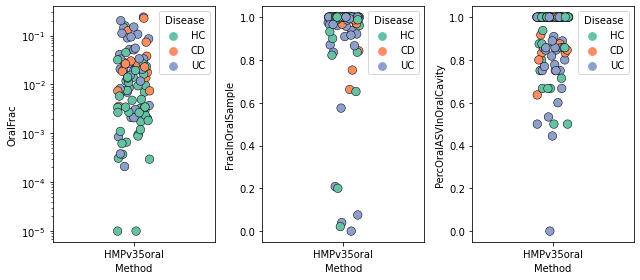

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

# oral bacterial fraction
df2plot = df_res[(df_res.Method=='HMPv35oral')]
df2plot.loc[df2plot.OralFrac == 0, 'OralFrac'] = 1e-5
_ = sns.stripplot(x="Method", y="OralFrac", data=df2plot, ax=ax[0], s=8.5, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)
_ = ax[0].set_yscale('log')

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.OralFrac > 1e-4]
_ = sns.stripplot(x="Method", y="FracInOralSample", data=df2plot, ax=ax[1], s=8.5, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.OralFrac > 1e-4]
_ = sns.stripplot(x="Method", y="PercOralASVInOralCavity", data=df2plot, ax=ax[2], s=8.5, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)


plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("IBD_oral_bacteria_fraction_in_stool_HMP.svg", dpi=600, bbox_inches='tight')

In [17]:
df_res[(df_res.Disease=='HC') & (df_res.Method=='HMPv35oral')].OralFrac.mean()

0.011387985142254295

In [18]:
df_res[(df_res.Disease=='CD') & (df_res.Method=='HMPv35oral')].OralFrac.mean()

0.04214400762028497

In [19]:
df_res[(df_res.Disease=='UC') & (df_res.Method=='HMPv35oral')].OralFrac.mean()

0.04270553749180792

In [20]:
# df_res2 = df_res[df_res.Method=='HMPv35oral']
# print(len(df_res2[df_res2.Disease !='HC']))
# print(len(df_res2[(df_res2.Disease !='HC') & (df_res2.PercOralASVInOralCavity>=0.7)]))
# print(len(df_res2[(df_res2.Disease !='HC') & (df_res2.PercOralASVInOralCavity==1)]))
df_res2 = df_res[df_res.Method=='HMPv35oral']
print(len(df_res2[df_res2.OralFrac>0]))
print(len(df_res2[(df_res2.OralFrac>0) & (df_res2.PercOralASVInOralCavity>0.7)]))
print(Counter(df_res2[(df_res2.OralFrac>0) & (df_res2.PercOralASVInOralCavity>0.7)].Disease))
print(len(df_res2[(df_res2.OralFrac>0) & (df_res2.PercOralASVInOralCavity==1)]))
print(Counter(df_res2[(df_res2.OralFrac>0) & (df_res2.PercOralASVInOralCavity==1)].Disease))

99
87
Counter({'HC': 36, 'UC': 36, 'CD': 15})
52
Counter({'HC': 29, 'UC': 16, 'CD': 7})


In [21]:
# df_res2 = df_res[df_res.Method=='HMPv35oral']
# print(len(df_res2[df_res2.Disease !='HC']))
# print(len(df_res2[(df_res2.Disease !='HC') & (df_res2.FracInOralSample>=0.7)]))
# print(len(df_res2[(df_res2.Disease !='HC') & (df_res2.FracInOralSample==1)]))
df_res2 = df_res[df_res.Method=='HMPv35oral']
print(len(df_res2[df_res2.OralFrac>0]))
print(len(df_res2[(df_res2.OralFrac>0) & (df_res2.FracInOralSample>0.7)]))
print(Counter(df_res2[(df_res2.OralFrac>0) & (df_res2.FracInOralSample>0.7)].Disease))
print(len(df_res2[(df_res2.OralFrac>0) & (df_res2.FracInOralSample==1)]))
print(Counter(df_res2[(df_res2.OralFrac>0) & (df_res2.FracInOralSample==1)].Disease))

99
90
Counter({'HC': 38, 'UC': 37, 'CD': 15})
40
Counter({'HC': 22, 'UC': 12, 'CD': 6})


In [22]:
# fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,12), sharex=True, sharey=True)

# #Create a matplotlib colormap from the sns purple color palette
# cmap    = sns.light_palette("purple", reverse=True, as_cmap=True )
# # Normalize to the range of possible values from df["c"]
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# # create a color dictionary (value in c : color from colormap) 
# colors = {}
# for cval in df_res.FracInOralSample:
#     colors.update({cval : cmap(norm(cval))})
    
# for k,d in enumerate(['HC','CD','UC']):
#     _ = sns.stripplot(x="Method", y="OralFrac", data=df_res[df_res.Disease==d], ax=ax[k], order=['HOMD','fHOMD','HMPv35oral'], size=6, 
#                       hue='FracInOralSample', palette = colors, s=6, edgecolor='k', linewidth=0.5)
#     _ = ax[k].legend_.remove()
#     _ = ax[k].set_yscale('log')
#     _ = ax[k].set_ylim([2e-4,2])
# divider = make_axes_locatable(plt.gca())
# ax_cb = divider.new_horizontal(size="5%", pad=0.05)
# fig.add_axes(ax_cb)
# cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
# cb1.set_label('Fraction present in oral cavity')

# plt.tight_layout()
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("compare_oral_estimation_methods.svg", dpi=600, bbox_inches='tight')

# Compare to HOMD

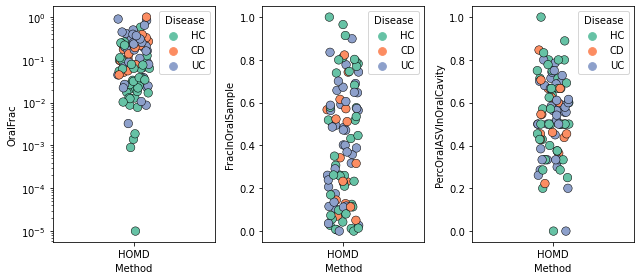

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

# oral bacterial fraction
df2plot = df_res[(df_res.Method=='HOMD')]
df2plot.loc[df2plot.OralFrac == 0, 'OralFrac'] = 1e-5
_ = sns.stripplot(x="Method", y="OralFrac", data=df2plot, ax=ax[0], s=8.5, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)
_ = ax[0].set_yscale('log')

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.OralFrac > 1e-4]
_ = sns.stripplot(x="Method", y="FracInOralSample", data=df2plot, ax=ax[1], s=8.5, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.OralFrac > 1e-4]
_ = sns.stripplot(x="Method", y="PercOralASVInOralCavity", data=df2plot, ax=ax[2], s=8.5, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("IBD_oral_bacteria_fraction_in_stool_HOMD.svg", dpi=600, bbox_inches='tight')

# Overlap of ASVs inferred by different approach

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/3924193391.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/3924193391.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))]
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/3924193391.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_gut_mean_relabun = df_relabun.loc[set(df_rel

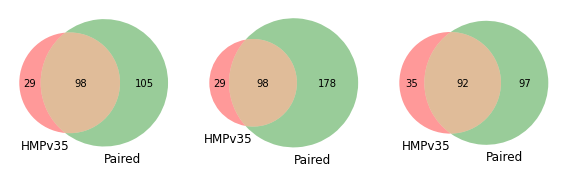

In [24]:
oral_typical_HMP = set(list(df_blast_HMPv35oral.query_accver))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
for k,disease in enumerate(['HC','CD','UC']):
    df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
    df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))]
    df_oral_prevalence = (df_oral_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Oral'}, axis=1)
    df_oral = pd.merge(df_oral_mean_relabun, df_oral_prevalence, left_index=True, right_index=True, how='inner')

    df_gut_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='stool')].index))].mean().to_frame().rename({0:'MeanRelabun_Gut'}, axis=1)
    df_gut_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='stool')].index))]
    df_gut_prevalence = (df_gut_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Gut'}, axis=1)
    df_gut = pd.merge(df_gut_mean_relabun, df_gut_prevalence, left_index=True, right_index=True, how='inner')
    
    df = pd.merge(df_oral, df_gut, left_index=True, right_index=True, how='left').fillna(0)
    relabun_cutoff = 1e-4
    prevalence_cutoff = 0.05
    df['Is_Oral'] = False
    df.loc[(df.MeanRelabun_Oral > relabun_cutoff) & (df.Prevalence_Oral > prevalence_cutoff) & (df.MeanRelabun_Gut <= relabun_cutoff) & (df.Prevalence_Gut <= prevalence_cutoff), 'Is_Oral'] = True
    filtered_oral_asvs = set(list(df[df.Is_Oral==True].index))

    # plot Venn diagram
    asv_overlap = len(oral_typical_HMP.intersection(filtered_oral_asvs))
    asv_hmp_only = len(oral_typical_HMP-filtered_oral_asvs)
    asv_paired_only = len(filtered_oral_asvs - oral_typical_HMP)
    _ = venn2(subsets = (asv_hmp_only, asv_paired_only, asv_overlap), set_labels = ('HMPv35', 'Paired'), ax=ax[k])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("venn_diagram_asv_overalp.svg", dpi=600, bbox_inches='tight')

# Comparison of oral bacterial fraction by different approach

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/3555609146.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/3555609146.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))]
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/3555609146.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_gut_mean_relabun = df_relabun.loc[set(df_rel

AssertionError: 

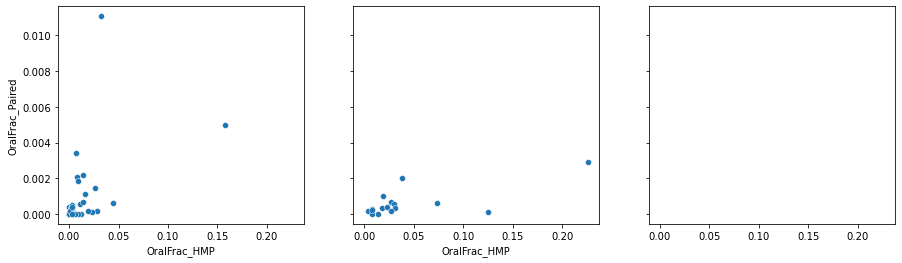

In [25]:
oral_typical_HMP = set(list(df_blast_HMPv35oral.query_accver))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharex=True, sharey=True)
for k,disease in enumerate(['HC','CD','UC']):
    df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
    df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='saliva')].index))]
    df_oral_prevalence = (df_oral_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Oral'}, axis=1)
    df_oral = pd.merge(df_oral_mean_relabun, df_oral_prevalence, left_index=True, right_index=True, how='inner')

    df_gut_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='stool')].index))].mean().to_frame().rename({0:'MeanRelabun_Gut'}, axis=1)
    df_gut_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='stool')].index))]
    df_gut_prevalence = (df_gut_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Gut'}, axis=1)
    df_gut = pd.merge(df_gut_mean_relabun, df_gut_prevalence, left_index=True, right_index=True, how='inner')
    
    df = pd.merge(df_oral, df_gut, left_index=True, right_index=True, how='left').fillna(0)
    relabun_cutoff = 1e-4
    prevalence_cutoff = 0.05
    df['Is_Oral'] = False
    df.loc[(df.MeanRelabun_Oral > relabun_cutoff) & (df.Prevalence_Oral > prevalence_cutoff) & (df.MeanRelabun_Gut <= relabun_cutoff) & (df.Prevalence_Gut <= prevalence_cutoff), 'Is_Oral'] = True
    filtered_oral_asvs = set(list(df[df.Is_Oral==True].index))

    df2 = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[(df_meta.Disease==disease) & (df_meta.BodySite=='stool')].index))]
    df3 = pd.merge(df2[oral_typical_HMP].sum(axis=1).to_frame(),
                   df2[filtered_oral_asvs].sum(axis=1).to_frame(),
                   left_index=True, right_index=True, how='inner')
    df3.columns = ['OralFrac_HMP', 'OralFrac_Paired']
    _ = sns.scatterplot(x="OralFrac_HMP", y="OralFrac_Paired", data=df3, ax=ax[k])
    
    if disease=='CD':
        assert 0

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_oral_fraction_comp.svg", dpi=600, bbox_inches='tight')

In [26]:
'fd496fd32dc8c08ade2e8b6c9d8ee13d'

'fd496fd32dc8c08ade2e8b6c9d8ee13d'

In [27]:
df_oral_prevalence.loc['fd496fd32dc8c08ade2e8b6c9d8ee13d']

Prevalence_Oral    0.9375
Name: fd496fd32dc8c08ade2e8b6c9d8ee13d, dtype: float64

In [28]:
df_gut_mean_relabun.loc['fd496fd32dc8c08ade2e8b6c9d8ee13d']

MeanRelabun_Gut    0.020812
Name: fd496fd32dc8c08ade2e8b6c9d8ee13d, dtype: float64

## Correlate oral bacterial fraction and sequencing depth

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/2847649217.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_count_sum = pd.merge(df_count_sum, df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1),
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_58604/2847649217.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_count_sum = df_count_sum.loc[set(df_res.index)]


SpearmanrResult(correlation=0.3956330682400824, pvalue=4.222522209762245e-05)


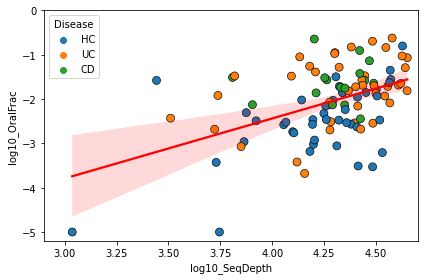

In [29]:
# compute sequence depth
df_count_sum = pd.merge(df_meta[df_meta.BodySite=='stool'], df_count.sum(axis=1).to_frame().rename({0:'SeqDepth'}, axis=1), left_index=True, right_index=True, how='inner')
df_count_sum = pd.merge(df_count_sum, df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1),
                        left_index=True, right_index=True, how='inner')
df_count_sum = df_count_sum.loc[set(df_res.index)]
df_count_sum.loc[df_count_sum.OralFrac==0,'OralFrac'] = 1e-5
df_count_sum['log10_SeqDepth'] = np.log10(df_count_sum['SeqDepth'])
df_count_sum['log10_OralFrac'] = np.log10(df_count_sum['OralFrac'])

# spearman correlation
print(spearmanr(df_count_sum.log10_SeqDepth, df_count_sum.log10_OralFrac))

fig, ax = plt.subplots(figsize=(6,4))
_ = sns.scatterplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, s=64, color='lightgray', edgecolor='k', hue='Disease')
_ = sns.regplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, scatter=False, color="red")
_ = ax.set_ylim([-5.2,-0])
_ = ax.set_xlim([2.9,4.7])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_depth_vs_oral_fraction.svg", dpi=600, bbox_inches='tight')

In [30]:
scipy.stats.linregress(x=df_count_sum.log10_SeqDepth, y=df_count_sum.log10_OralFrac)

LinregressResult(slope=1.3541686324325029, intercept=-7.854415219651871, rvalue=0.46730250011995983, pvalue=8.369554555236486e-07, stderr=0.2574881256529808, intercept_stderr=1.104022705375726)

# Plot oral bacterial enrichment in CD and UC patients

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. CD: Kruskal-Wallis paired samples, P_val=8.197e-05 stat=1.551e+01
HC v.s. UC: Kruskal-Wallis paired samples, P_val=9.512e-05 stat=1.523e+01


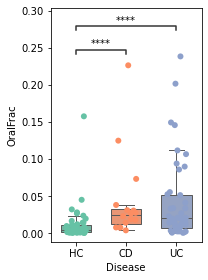

In [31]:
fig, ax = plt.subplots(figsize=(3,4))
df2plot = pd.merge(df_meta, df_res[df_res.Method=='HMPv35oral'].drop('Disease',axis=1), left_index=True, right_index=True, how='inner')
#df2plot = df2plot[df2plot.OralFrac>0]
#df2plot['log10_OralFrac'] = np.log10(df2plot['OralFrac'])

_ = sns.boxplot(y="OralFrac", x="Disease", data=df2plot, width=.6, ax=ax, order=['HC','CD','UC'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="OralFrac", x="Disease", data=df2plot, size=6, color=".3", linewidth=0, ax=ax, jitter=0.2, palette='Set2', dodge=True, order=['HC','CD','UC'])
_ = add_stat_annotation(ax, data=df2plot, y="OralFrac", x="Disease", order=['HC','CD','UC'],
                        comparisons_correction=None,
                        box_pairs=[("HC","CD"),("HC","UC")],
                        test='Kruskal', text_format='star', loc='inside', verbose=1)
#_ = ax.set_ylim([-4,1.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("oral_enrichment_in_IBD.svg", dpi=600)

In [34]:
Counter(df2plot.Disease)

Counter({'CD': 16, 'UC': 42, 'HC': 43})

# Show changes in oral bacterial fraction at more stringent criteria

In [104]:
df_blast_HMPv35 = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35/blast_HMPv35_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [105]:
df_cutoff = pd.read_csv("../../build_human_reference_database/oral_typical_seqs_vary_cutoffs.csv", index_col=0)
df_cutoff.head()

,"1.00e-04, 5.00e-02, 1.00e-04","1.00e-04, 5.00e-02, 1.00e-03","1.00e-04, 1.00e-01, 1.00e-04","1.00e-04, 1.00e-01, 1.00e-03","1.00e-03, 5.00e-02, 1.00e-04","1.00e-03, 5.00e-02, 1.00e-03","1.00e-03, 1.00e-01, 1.00e-04","1.00e-03, 1.00e-01, 1.00e-03"
#OTU ID,,,,,,,,
0096a273ac0abbb04557fff40774244c,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0863adf64994d46f2342303cdd22bde9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
08a4d4e95b0f4a7f11cd17b916fc366b,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
0936f17723be73c6e5220d3bb175d53b,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
0c26d5527a0f5dd2c2701bb297ac96b9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
df_oral_fracs = None
for col in df_cutoff.columns:
    relabun_cutoff = float(col.split(', ')[0])
    prevalence_cutoff = float(col.split(', ')[1])
    hmp_oral_typical = list(df_cutoff[df_cutoff[col]==1].index)
    hits = set(df_blast_HMPv35[df_blast_HMPv35.subject_accver.isin(hmp_oral_typical)].query_accver).intersection(set(df_relabun.columns))
    oral_fracs = df_relabun.loc[set(df_meta[df_meta.BodySite=='stool'].index).intersection(set(df_relabun.index)), hits].sum(axis=1).to_frame().rename({0:col}, axis=1)
    if df_oral_fracs is None:
        df_oral_fracs = deepcopy(oral_fracs)
    else:
        df_oral_fracs = pd.merge(df_oral_fracs, oral_fracs, left_index=True, right_index=True, how='inner')
df_oral_fracs = pd.merge(df_oral_fracs, df_meta[['Disease']], left_index=True, right_index=True, how='left').sort_values('Disease')
df_oral_fracs.columns = [(',').join(['%s%%' % str(float(x)*100) for x in col.split(', ')]) if col != 'Disease' else 'Disease' for col in df_oral_fracs.columns]
df_oral_fracs.head()

,"0.01%,5.0%,0.01%","0.01%,5.0%,0.1%","0.01%,10.0%,0.01%","0.01%,10.0%,0.1%","0.1%,5.0%,0.01%","0.1%,5.0%,0.1%","0.1%,10.0%,0.01%","0.1%,10.0%,0.1%",Disease
SRR13302346,0.016925,0.030218,0.028822,0.028822,0.014970,0.028263,0.028263,0.028263,CD
SRR13302278,0.121363,0.124549,0.084980,0.084980,0.169657,0.172844,0.133275,0.133275,CD
SRR13302299,0.021930,0.026344,0.025231,0.025231,0.021678,0.026093,0.026093,0.026093,CD
SRR13302281,0.001994,0.003574,0.003574,0.003574,0.003085,0.004664,0.004664,0.004664,CD
SRR13302350,0.055862,0.072951,0.072032,0.072032,0.101341,0.118430,0.118430,0.118430,CD


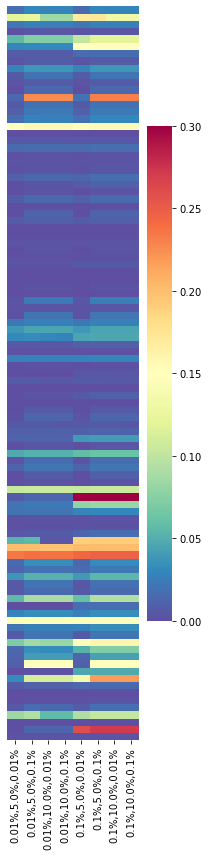

In [135]:
fig, ax = plt.subplots(figsize=(3,12))

# change relative abundance
_ = sns.heatmap(
    df_oral_fracs.iloc[:,0:-1],
    vmin=0,
    vmax=0.3,
    cmap='Spectral_r',
    yticklabels=False,
    ax=ax
)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("oral_enrichment_in_IBD.svg", dpi=600)

In [109]:
Counter(df_oral_fracs.Disease)

Counter({'CD': 16, 'HC': 43, 'UC': 42})